# Week 1 Homework (Notebook Version): Multi-Layer Perceptron for MNIST

**Due**: February 1, 2026 (before seminar)  
**Submission**: You will receive instructions soon on how/where to upload — check your email or the club's Discord.  
**Estimated Time**: 5–7 hours

> **Important:** This version assumes you do *everything* in this single Jupyter notebook.
> Wherever you see `TODO`, you will fill in the missing code **in-place**.

---
## Learning Objectives
By completing this homework, you will be able to:
- Implement a multi-layer perceptron (MLP) architecture in PyTorch
- Understand and apply backpropagation through hands-on implementation
- Train a neural network using stochastic gradient descent (SGD) or Adam
- Evaluate model performance with accuracy and a confusion matrix
- Debug common training issues (vanishing gradients, overfitting, poor initialization)


## Prerequisites Checklist

Before starting, make sure you:
- [ ] Watched all Week 1 MUST lectures (CS230 Lecture 2, GAIA Intro to NN, Backpropagation, Deep Dive 1)
- [ ] Have Python 3.8+ and PyTorch 2.0+ available (Colab already has these)
- [ ] Understand at least the basics of:
  - Matrix multiplication
  - Chain rule for derivatives
  - Cross-entropy loss
  - Python classes and functions

Run the cell below to test your environment.

In [1]:
# Environment Setup Test
import torch
import torchvision
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


In [2]:
"""Common imports used across the notebook.
You shouldn't need to change this cell, but you can add imports if needed."""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
#note: common errors here might be about torch and torchvision verson mismatch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


---
## Task 1: Implement the MLP Architecture (35 points)

**Goal:** Implement a flexible MLP for MNIST entirely inside this notebook.

**Thumb rule:**
- Flatten 28×28 → 784, then do `Linear → Activation` for each hidden layer.
- **No activation** on the final output layer (you'll use `CrossEntropyLoss`, which expects logits).


In [14]:
class MLP(nn.Module):
    """Multi-Layer Perceptron for MNIST classification.

    Args:
        input_size (int): Number of input features (784 for MNIST)
        hidden_sizes (list[int]): List of hidden layer sizes, e.g., [128, 64]
        output_size (int): Number of output classes (10 for MNIST)
        activation (str): 'relu', 'sigmoid', or 'tanh'
    """
    def __init__(self, input_size=784, hidden_sizes=[128, 64],
                 output_size=10, activation='relu'):
        super().__init__()

        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        # TODO: choose activation module based on string
        # self.activation_fn = ...

        if activation.lower() == 'relu':
            self.activation_fn = nn.ReLU()
        elif activation.lower() == 'sigmoid':
            self.activation_fn = nn.Sigmoid()
        elif activation.lower() == 'tanh':
            self.activation_fn = nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        # TODO: build a list of linear layers for hidden layers
        # Hints:
        # - Use nn.ModuleList()
        # - First layer: input_size -> hidden_sizes[0]
        # - Middle layers: hidden_sizes[i] -> hidden_sizes[i+1]
        # - Final layer: last hidden size -> output_size (store as self.output_layer)

        # Example outline (not complete):
        layers = []
        in_dim = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            in_dim = h
        self.hidden_layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(in_dim, output_size)



    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Args:
            x: Tensor of shape (batch_size, 1, 28, 28)
        Returns:
            Logits of shape (batch_size, 10)
        """
        # TODO: 1) flatten images to (batch_size, 784)
        #       2) pass through each hidden layer + activation
        #       3) pass through output layer (no activation)
        x = x.view(x.size(0), -1)
        for layer in self.hidden_layers:
            x = self.activation_fn(layer(x))
        x = self.output_layer(x)
        return x



In [15]:
# === Checkpoint 1: basic sanity check for MLP ===
try:
    model = MLP(input_size=784, hidden_sizes=[128, 64], output_size=10)
    test_input = torch.randn(32, 1, 28, 28)
    output = model(test_input)
    print("Output shape:", output.shape)
    print("Number of parameters:", sum(p.numel() for p in model.parameters()))
except NotImplementedError as e:
    print("NotImplementedError:", e)
    print("\nFill in the TODOs in the MLP class and re-run this cell.")

Output shape: torch.Size([32, 10])
Number of parameters: 109386


---
## Task 2: Data Loading and Preprocessing (15 points)

**Goal:** Implement MNIST data loaders and simple visualization directly in this notebook.

**Thumb rule:**
- Always normalize MNIST with mean `0.1307` and std `0.3081`.
- Shuffle the **training** loader, keep the **test** loader deterministic.


In [19]:
def get_mnist_loaders(batch_size=64, data_dir='./data'):
    """Create train and test DataLoaders for MNIST.

    Returns:
        train_loader, test_loader
    """
    # TODO: define transforms: ToTensor + Normalize(mean=0.1307, std=0.3081)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # TODO: load train and test datasets (datasets.MNIST)
    train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(data_dir, train=False, download=True, transform=transform)

    # TODO: wrap them in DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader



def visualize_samples(loader, num_samples=16):
    """Visualize a few random samples from a DataLoader.

    This is mainly for you to sanity check that data loading & normalization work.
    """
    # TODO: implement a simple grid of images with labels.
    # Hints:
    # - Get one batch: images, labels = next(iter(loader))
    # - Undo normalization for plotting if you like (optional)
    # - Use matplotlib: plt.subplots and imshow
    images, labels = next(iter(loader))

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        if i >= num_samples:
            break
        img = images[i].squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [20]:
# === Checkpoint 2: test your data loaders ===
try:
    train_loader, test_loader = get_mnist_loaders(batch_size=64)
    print("Training batches:", len(train_loader))
    print("Test batches:", len(test_loader))

    images, labels = next(iter(train_loader))
    print("Batch images shape:", images.shape)
    print("Batch labels shape:", labels.shape)
    print(f"Image value range: [{images.min():.3f}, {images.max():.3f}]")

    # Optional: visualize
    # visualize_samples(train_loader)
except NotImplementedError as e:
    print("NotImplementedError:", e)
    print("\nFill in the TODOs in get_mnist_loaders / visualize_samples and re-run this cell.")

Training batches: 938
Test batches: 157
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
Image value range: [-0.424, 2.821]


---
## Task 3: Training and Evaluation Loops (30 points)

**Goal:** Write training and evaluation functions that you can reuse later.

**Thumb rule:**
- Training loop: `zero_grad → forward → loss → backward → step`.
- Evaluation loop: **no gradients**, just `forward → metrics`.


In [21]:
def train_one_epoch(model, train_loader, criterion, optimizer, device=device):
    """Train the model for one epoch.

    Returns (avg_loss, accuracy_percent).
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        # TODO: move images & labels to device
        # TODO: zero gradients
        # TODO: forward pass
        # TODO: compute loss
        # TODO: backward pass
        # TODO: optimizer step
        # TODO: accumulate total_loss and accuracy stats
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    avg_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion, device=device):
    """Evaluate model on a validation/test DataLoader.

    Returns (avg_loss, accuracy_percent).
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            # TODO: move to device
            # TODO: forward pass
            # TODO: compute loss
            # TODO: accumulate metrics (loss & accuracy)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [22]:
def train_model(model, train_loader, test_loader,
                num_epochs=10, learning_rate=0.001, device=device):
    """Full training pipeline used later for hyperparameter experiments."""
    model = model.to(device)

    # TODO: define criterion (CrossEntropyLoss) and optimizer (SGD or Adam)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # TODO: call train_one_epoch & evaluate
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}  | Test Acc: {test_acc:.2f}%")

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
    }

---
## Task 4: Hyperparameters & Target Performance (20 points)

**Goal:** Train your MLP from this notebook to reach **≥ 95% test accuracy**.

We'll define a helper to plot curves, then a main training cell where you can play with hyperparameters.


MLP(
  (activation_fn): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
)

Epoch 1/10


Train Loss: 0.2750 | Train Acc: 91.75%
Test Loss: 0.1529  | Test Acc: 95.13%

Epoch 2/10


Train Loss: 0.1187 | Train Acc: 96.33%
Test Loss: 0.0997  | Test Acc: 96.78%

Epoch 3/10


Train Loss: 0.0831 | Train Acc: 97.42%
Test Loss: 0.0935  | Test Acc: 97.03%

Epoch 4/10


Train Loss: 0.0613 | Train Acc: 98.01%
Test Loss: 0.0926  | Test Acc: 97.10%

Epoch 5/10


Train Loss: 0.0508 | Train Acc: 98.39%
Test Loss: 0.0791  | Test Acc: 97.68%

Epoch 6/10


Train Loss: 0.0417 | Train Acc: 98.66%
Test Loss: 0.0946  | Test Acc: 97.50%

Epoch 7/10


Train Loss: 0.0345 | Train Acc: 98.82%
Test Loss: 0.0954  | Test Acc: 97.28%

Epoch 8/10


Train Loss: 0.0286 | Train Acc: 99.08%
Test Loss: 0.1090  | Test Acc: 97.07%

Epoch 9/10


Train Loss: 0.0269 | Train Acc: 99.12%
Test Loss: 0.0905  | Test Acc: 97.70%

Epoch 10/10


Train Loss: 0.0244 | Train Acc: 99.20%
Test Loss: 0.0977  | Test Acc: 97.54%


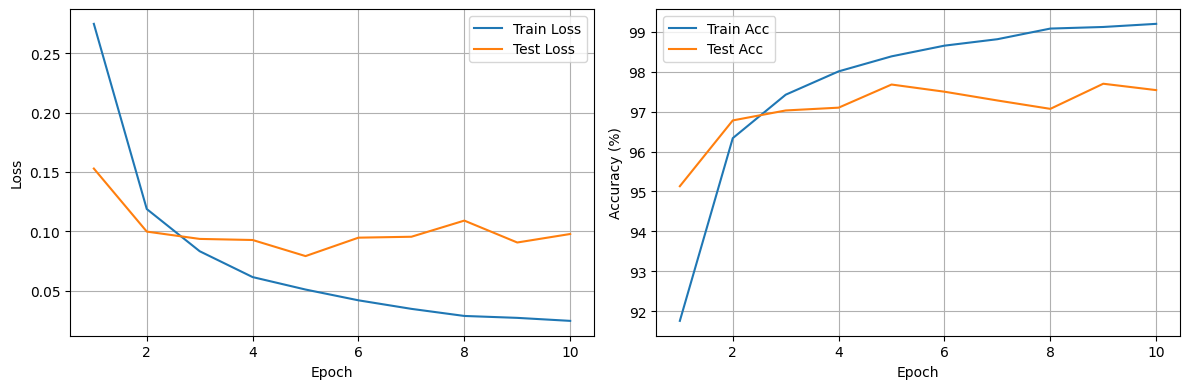

Final Test Accuracy: 97.54%


In [23]:
def plot_training_curves(history):
    """Plot training and test loss/accuracy curves."""
    epochs = range(1, len(history['train_losses']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(epochs, history['train_losses'], label='Train Loss')
    ax1.plot(epochs, history['test_losses'], label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, history['train_accs'], label='Train Acc')
    ax2.plot(epochs, history['test_accs'], label='Test Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# === Main training experiment cell ===
# Fill in after you have implemented MLP, data loaders, and training functions.
HIDDEN_SIZES = [128, 64]   # try also: [256], [256, 128, 64]
LEARNING_RATE = 0.001      # try also: 0.01, 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 10

try:
    train_loader, test_loader = get_mnist_loaders(batch_size=BATCH_SIZE)
    model = MLP(input_size=784,
                hidden_sizes=HIDDEN_SIZES,
                output_size=10,
                activation='relu')
    print(model)

    history = train_model(model, train_loader, test_loader,
                          num_epochs=NUM_EPOCHS,
                          learning_rate=LEARNING_RATE,
                          device=device)

    plot_training_curves(history)
    print(f"Final Test Accuracy: {history['test_accs'][-1]:.2f}%")
except NotImplementedError as e:
    print("NotImplementedError:", e)
    print("\nFinish the earlier TODOs (MLP, loaders, training loops) before running this cell.")

---
## Task 5: Analysis & Testing (10 points)

**Goal:** Understand your model's behavior using a confusion matrix, error analysis, and small automated tests.


In [26]:
def plot_confusion_matrix(model, data_loader, device=device):
    """Generate and display a confusion matrix for the test set."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            # TODO: move to device, run forward, collect predictions and labels
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # TODO: compute confusion matrix and plot using seaborn heatmap
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


def analyze_errors(model, data_loader, device=device, num_errors=10):
    """Visualize a few misclassified examples with predicted vs true labels."""
    model.eval()
    # TODO: collect misclassified samples, then show a grid of images
    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            idxs = (preds != labels).nonzero(as_tuple=True)[0]

            for idx in idxs:
                if len(misclassified_images) >= num_errors:
                    break
                misclassified_images.append(images[idx].cpu())
                misclassified_preds.append(preds[idx].cpu().item())
                misclassified_labels.append(labels[idx].cpu().item())

            if len(misclassified_images) >= num_errors:
                break

    plt.figure(figsize=(15, 3))
    for i in range(len(misclassified_images)):
        plt.subplot(1, len(misclassified_images), i+1)
        plt.imshow(misclassified_images[i].squeeze(), cmap='gray')
        plt.title(f"Pred: {misclassified_preds[i]}\nTrue: {misclassified_labels[i]}", color='red')
        plt.axis('off')
    plt.show()

Generating Confusion Matrix...


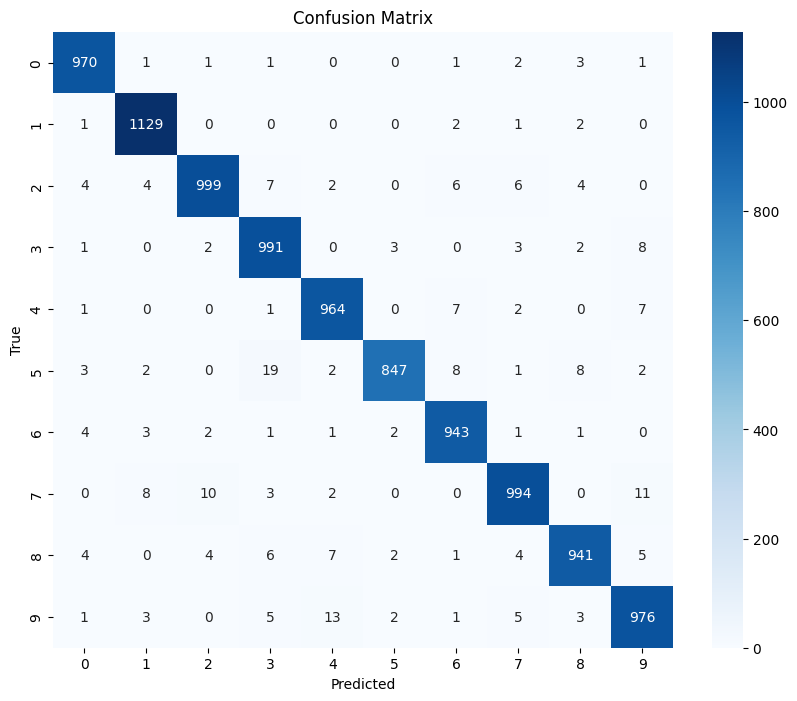


Visualizing Misclassified Examples...


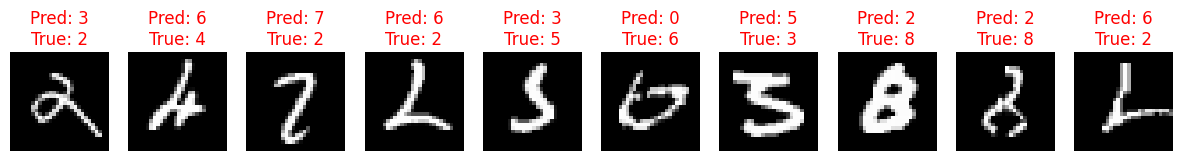

In [28]:
# === Analysis Execution ===
# Now that the functions are defined, let's run them on our trained model.

try:
    print("Generating Confusion Matrix...")
    plot_confusion_matrix(model, test_loader)

    print("\nVisualizing Misclassified Examples...")
    analyze_errors(model, test_loader)
except NameError:
    print("Error: 'model' or 'test_loader' not found. Make sure you ran the training cell (Task 4) first!")

In [27]:
def test_model_properties(model_cls=MLP):
    """Basic sanity checks for your MLP implementation."""
    print("Running model tests...\n")

    # Test 1: forward shape
    model = model_cls(784, [128, 64], 10)
    x = torch.randn(32, 1, 28, 28)
    out = model(x)
    assert out.shape == (32, 10), f"Wrong output shape: {out.shape}"
    print("✓ Forward output shape is correct")

    # Test 2: gradient flow
    loss = out.sum()
    loss.backward()
    has_grads = all(p.grad is not None for p in model.parameters() if p.requires_grad)
    assert has_grads, "Some parameters have no gradients"
    print("✓ Gradients flow through all parameters")

    # Test 3: batch size flexibility
    for bs in [1, 8, 64]:
        x = torch.randn(bs, 1, 28, 28)
        out = model(x)
        assert out.shape == (bs, 10), f"Failed for batch size {bs}"
    print("✓ Works for multiple batch sizes")

    print("\nAll model tests passed! ✨")


# Run this after you finish the MLP implementation
try:
    test_model_properties()
except NotImplementedError as e:
    print("NotImplementedError:", e)
    print("\nFinish the TODOs in MLP before running tests.")

Running model tests...

✓ Forward output shape is correct
✓ Gradients flow through all parameters
✓ Works for multiple batch sizes

All model tests passed! ✨


---
## Submission & Reflection

When you're done:
1. Save/export your finished notebook (`File → Download → .ipynb`).
2. Keep any file outputs you created while working (e.g., saved figures via `plt.savefig`). If you didn't produce any extra files, that's fine, but try to track your outputs in a way that is readable and understandable to another person.
3. You will receive instructions soon on how and where to upload your work — check your email or the club's Discord.
